In [117]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random

### Clean the data for all the Ego sessions separately from all the stereotype sessions. I start with ego sessions.

In [118]:
# import the data in wide format for eah session
session1 = pd.read_csv("../demo/data/session1_ego.csv")
session2 = pd.read_csv("../demo/data/session2_ego.csv")

# concatenate the two sessions
ego_wide = pd.concat([session1, session2], axis=0, sort=False)

#ego_wide = session1

ego_wide['treatment'] = 'ego'
ego_wide.reset_index(inplace=True)


/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_5782/2657362884.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ego_wide['treatment'] = 'ego'
/var/folders/fz/pp86wz7x4h514cs2lxtvtq3c0000gn/T/ipykernel_5782/2657362884.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ego_wide.reset_index(inplace=True)


In [119]:
# from the data frame ego_wide, select all the columns that have names that start with 'Quizzes' and append the column 'participant.code
quiz_cols = [col for col in ego_wide.columns if 'Quizzes' in col]+['participant.code', 'treatment']


# from the data frame ego_wide, select all the columns that have names that start with 'participant.'
participant_cols = [col for col in ego_wide.columns if 'participant' in col]+['participant.code']

# from the data frame ego_wide, select all the columns that have names that start with 'session.'
session_cols = [col for col in ego_wide.columns if 'session' in col]+['participant.code']

# from the data frame ego_wide, select all the columns that have names that start with 'Signals.'
signal_cols = [col for col in ego_wide.columns if 'Signals' in col]+['participant.code']

# from the data frame ego_wide, select all the columns that have names that start with 'SignalsOther.'
signal_other_cols = [col for col in ego_wide.columns if 'SignalsOther' in col]+['participant.code']

# from the data frame ego_wide, select all the columns that have names that start with 'Questionnaire.'
questionnaire_cols = [col for col in ego_wide.columns if 'Questionnaire' in col]+['participant.code']


In [120]:
# split the data frame ego_wide into 6 data frames using the columns we just selected
ego_quiz = ego_wide[quiz_cols]
ego_participant = ego_wide[participant_cols]
ego_session = ego_wide[session_cols]
ego_signal = ego_wide[signal_cols]
ego_signal_other = ego_wide[signal_other_cols] # this has no information for the ego treatment
ego_questionnaire = ego_wide[questionnaire_cols]

## Quiz Scores
First I will clean the data for the first part of the experiment to get only the true scores.

In [121]:
# for ego_quiz rename all the columns to remove the prefix 'Quizzes'
ego_quiz.columns = [col.replace('Quizzes.','') for col in ego_quiz.columns]
# for ego_quiz rename all the columns to remove the prefix 'player'
ego_quiz.columns = [col.replace('player.','') for col in ego_quiz.columns]
# drop all the columns that have either 'group.' or 'subsession.' in the name
ego_quiz = ego_quiz[[col for col in ego_quiz.columns if 'group.' not in col and 'subsession.' not in col]]
# melt the data making the participant code the id variable
ego_quiz_long = pd.melt(ego_quiz, id_vars=['participant.code'])
# split the variable column into two columns, one for the round_number and one for the question
ego_quiz_long[['round_number','variable_name']] = ego_quiz_long['variable'].str.split('.', expand=True)
# drop the column variable with the long names
ego_quiz_long = ego_quiz_long.drop('variable', axis=1)
# reshape ego_quiz_long from long to wide format by making each of the values in variable_name a column
ego_quiz_wide = ego_quiz_long.pivot(index=['participant.code','round_number'], columns=['variable_name'], values='value')
# make a table that has only the score for each topic and the participant code
ego_scores = ego_quiz_wide[['topic', 'score']]
# reset the index so that participant_code is just another colum
ego_scores.reset_index(inplace=True)

### Participant level variables

In [122]:
# rename all the other variables withoutht the 'participant.' prefix
ego_participant.columns = [col.replace('participant.','') for col in ego_participant.columns]


## The variables from the main part of the experiment
This table has all the effort choices and signal realizations round by round. It also has the beliefs about their score and the buttons clicked for the type matixes

In [123]:
# from ego_signal drop all the columns that have the 'SignalsOther.' prefix
ego_signal = ego_signal[[col for col in ego_signal.columns if 'SignalsOther.' not in col]]

# remove the 'Signals.' prefix from all the column names and the 'participant.' prefix from the code column
ego_signal.columns = [col.replace('Signals.','') for col in ego_signal.columns]
ego_signal.columns = [col.replace('participant.','') for col in ego_signal.columns]
# replace the 'player.' in the names of the columns
ego_signal.columns = [col.replace('player.', '') for col in ego_signal.columns]

# drop the group and subsession level columns
ego_signal = ego_signal[[col for col in ego_signal.columns if 'group.' not in col and '.subsession' not in col]]

# melt the data set making code the id column. then split all the variable names
ego_signal_long = pd.melt(ego_signal, id_vars='code')

In [124]:
# split the variable column into two columns, one for the round_number and one for the question
ego_signal_long[['round_number','variable_name']] = ego_signal_long['variable'].str.split('.', expand=True)
# drop the column variable with the long names
ego_signal_long = ego_signal_long.drop('variable', axis=1)

# reshape ego_signal_long from long to wide format by making each of the values in variable_name a column
ego_signal_wide = ego_signal_long.pivot(index=['code','round_number'], columns=['variable_name'], values='value')
ego_signal_wide.reset_index(inplace=True)

In [125]:
beliefs = ego_signal_wide.loc[ego_signal_wide['science_belief']>=0, 
                    ['code','science_belief', 'us_belief', 'math_belief', 'verbal_belief', 'pop_belief', 'sports_belief',
                    'science_certainty', 'us_certainty', 'math_certainty', 'verbal_certainty', 'pop_certainty', 'sports_certainty']]

In [126]:
# the round_numbers range from 1 to 60. I want all of them to range from 1 to 11 by setting 11 to 1, 21 to 1, 12 to 2, etc.
ego_signal_wide['round_number'] = ego_signal_wide['round_number'].astype(int)

ego_signal_wide['round_number'].replace([12,23,34,45,56], 1, inplace=True)
ego_signal_wide['round_number'].replace([13,24,35,46,57], 2, inplace=True)
ego_signal_wide['round_number'].replace([14,25,36,47,58], 3, inplace=True)
ego_signal_wide['round_number'].replace([15,26,37,48,59], 4, inplace=True)
ego_signal_wide['round_number'].replace([16,27,38,49,60], 5, inplace=True)
ego_signal_wide['round_number'].replace([17,28,39,50,61], 6, inplace=True)
ego_signal_wide['round_number'].replace([18,29,40,51,62], 7, inplace=True)
ego_signal_wide['round_number'].replace([19,30,41,52,63], 8, inplace=True)
ego_signal_wide['round_number'].replace([20,31,42,53,64], 9, inplace=True)
ego_signal_wide['round_number'].replace([21,32,43,54,65], 10, inplace=True)
ego_signal_wide['round_number'].replace([22,33,44,55,66], 11, inplace=True)


### Split the signal stage by topic. 
For all participants, they got the same exogenous rate and the same order of signals for each topic.
I will then merge the topics that have the same exchange rate and the same order of signals.

there are nine combinations of type and rate that each participant could have had in each topic. Those 9 pairs are the ones I am interested in. 

In [127]:
ego_science = ego_signal_wide.loc[(ego_signal_wide['effort']>=0) & (ego_signal_wide['topic']=='Science and Technology'), 
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'science_score', 'topic', 'signal']]
# impute the values for science_belief and the science_certainty from the table beliefs
ego_science = ego_science.merge(beliefs[['code', 'science_belief', 'science_certainty']], on='code', how='left')

# add a column with the type according to the science score
ego_science.loc[ego_science['science_score']>15, 'type'] = '2'
ego_science.loc[ego_science['science_score']<=15, 'type'] = '1'
ego_science.loc[ego_science['science_score']<6, 'type'] = '0'

# make a data frame for math exactly as ego_science but with the math score and belief
ego_math = ego_signal_wide.loc[(ego_signal_wide['effort']>=0) & (ego_signal_wide['topic']=='Math'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'math_score', 'topic', 'signal']]
# impute the values for math_belief and the math_certainty from the table beliefs
ego_math = ego_math.merge(beliefs[['code', 'math_belief', 'math_certainty']], on='code', how='left')

# add a column with the type according to the science score
ego_math.loc[ego_math['math_score']>15, 'type'] = '2'
ego_math.loc[ego_math['math_score']<=15, 'type'] = '1'
ego_math.loc[ego_math['math_score']<6, 'type'] = '0'

# make a data frame for verbal exactly as ego_science but with the verbal score and belief
ego_verbal = ego_signal_wide.loc[(ego_signal_wide['effort']>=0) & (ego_signal_wide['topic']=='Verbal'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'verbal_score', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
ego_verbal = ego_verbal.merge(beliefs[['code', 'verbal_belief', 'verbal_certainty']], on='code', how='left')

# add a column with the type according to the science score
ego_verbal.loc[ego_verbal['verbal_score']>15, 'type'] = '2'
ego_verbal.loc[ego_verbal['verbal_score']<=15, 'type'] = '1'
ego_verbal.loc[ego_verbal['verbal_score']<6, 'type'] = '0'

# make a data frame for verbal exactly as ego_science but with the verbal score and belief
ego_pop = ego_signal_wide.loc[(ego_signal_wide['effort']>=0) & (ego_signal_wide['topic']=='Pop-Culture and Art'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'pop_score', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
ego_pop = ego_pop.merge(beliefs[['code', 'pop_belief', 'pop_certainty']], on='code', how='left')

# add a column with the type according to the science score
ego_pop.loc[ego_pop['pop_score']>15, 'type'] = '2'
ego_pop.loc[ego_pop['pop_score']<=15, 'type'] = '1'
ego_pop.loc[ego_pop['pop_score']<6, 'type'] = '0'

# make a data frame for verbal exactly as ego_science but with the verbal score and belief
ego_sports = ego_signal_wide.loc[(ego_signal_wide['effort']>=0) & (ego_signal_wide['topic']=='Sports and Video Games'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'sports_score', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
ego_sports = ego_sports.merge(beliefs[['code', 'sports_belief', 'sports_certainty']], on='code', how='left')

# add a column with the type according to the science score
ego_sports.loc[ego_sports['sports_score']>15, 'type'] = '2'
ego_sports.loc[ego_sports['sports_score']<=15, 'type'] = '1'
ego_sports.loc[ego_sports['sports_score']<6, 'type'] = '0'

# make a data frame for verbal exactly as ego_science but with the verbal score and belief
ego_us = ego_signal_wide.loc[(ego_signal_wide['effort']>=0) & (ego_signal_wide['topic']=='US Geography'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'us_score', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
ego_us = ego_us.merge(beliefs[['code', 'us_belief', 'us_certainty']], on='code', how='left')

# add a column with the type according to the science score
ego_us.loc[ego_us['us_score']>15, 'type'] = '2'
ego_us.loc[ego_us['us_score']<=15, 'type'] = '1'
ego_us.loc[ego_us['us_score']<6, 'type'] = '0'

## Get the rate values for each topic
The rate values are saved at the session level and are the same across all rounds because the seed was set at the beginning

In [128]:
# from the ego session data frame select only the columns that we will use
ego_session = ego_session[['participant.id_in_session', 
                            'session.code', 
                            'session.w_verbal', 
                            'session.w_math', 
                            'session.w_pop',
                            'session.w_science',
                            'session.w_sports',
                            'session.w_us']]


In [129]:
# in ego_session remove the prefixes 'participant.' and 'session.' from the column names
ego_session.columns = [col.replace('participant.','') for col in ego_session.columns]
ego_session.columns = [col.replace('session.','') for col in ego_session.columns]
# add a column to each of the topics tables with the corresponding value of w from the ego_session table
ego_science['rate']=ego_session['w_science'][0]
ego_math['rate']=ego_session['w_math'][0]
ego_verbal['rate']=ego_session['w_verbal'][0]
ego_pop['rate']=ego_session['w_pop'][0]
ego_sports['rate']=ego_session['w_sports'][0]
ego_us['rate']=ego_session['w_us'][0]

## name homogenization
Make all the toipic tables have the same column names so that they can be merged into one table

In [130]:
# from ego_science remove the prefix 'science_' from the column names that have it
ego_science.columns = [col.replace('science_','') for col in ego_science.columns]

# from ego_math remove the prefix 'math_' from the column names that have it
ego_math.columns = [col.replace('math_','') for col in ego_math.columns]

# from ego_verbal remove the prefix 'verbal_' from the column names that have it
ego_verbal.columns = [col.replace('verbal_','') for col in ego_verbal.columns]

# from ego_pop remove the prefix 'pop_' from the column names that have it
ego_pop.columns = [col.replace('pop_','') for col in ego_pop.columns]

# from ego_sports remove the prefix 'sports_' from the column names that have it
ego_sports.columns = [col.replace('sports_','') for col in ego_sports.columns]

# from ego_us remove the prefix 'us_' from the column names that have it
ego_us.columns = [col.replace('us_','') for col in ego_us.columns]

# stack all the topic tables into one larger data frame called ego_updates
ego_updates = pd.concat([ego_science, ego_math, ego_verbal, ego_pop, ego_sports, ego_us])
ego_updates.reset_index(inplace=True, drop=True)


## separate into 9 types:
low type, low rate

low type, medium rate

low type, high rate

medium type, low rate

medium type, medium rate

medium type, high rate

high type, low rate

high type, medium rate

high type, high rate

In [131]:
# add a colun that indicates the treatment
ego_updates['treatment'] = 'ego'

# turn the type column into an integer
ego_updates['type'] = ego_updates['type'].astype(int)

# add a column that indicates if the participant was overconfident
ego_updates['overconfident'] = 0
ego_updates.loc[ego_updates['type']<ego_updates['belief'], 'overconfident'] = 1

# add a column that indicates if the participant was underconfident
ego_updates['underconfident'] = 0
ego_updates.loc[ego_updates['type']>ego_updates['belief'], 'underconfident'] = 1

# add a column that indicates if the participant was correct
ego_updates['correct']=0
ego_updates.loc[ego_updates['type']==ego_updates['belief'], 'correct'] = 1

# create a table for each pair of theta and omega (type and rate) the subindexes are in that order
#low types
updates_ll = ego_updates.loc[(ego_updates['type']==0) & (ego_updates['rate']==0), :]
updates_lm = ego_updates.loc[(ego_updates['type']==0) & (ego_updates['rate']==1), :]
updates_lh = ego_updates.loc[(ego_updates['type']==0) & (ego_updates['rate']==2), :]

# mid types
updates_ml = ego_updates.loc[(ego_updates['type']==1) & (ego_updates['rate']==0), :]
updates_mm = ego_updates.loc[(ego_updates['type']==1) & (ego_updates['rate']==1), :]
updates_mh = ego_updates.loc[(ego_updates['type']==1) & (ego_updates['rate']==2), :]

# high types
updates_hl = ego_updates.loc[(ego_updates['type']==2) & (ego_updates['rate']==0), :]
updates_hm = ego_updates.loc[(ego_updates['type']==2) & (ego_updates['rate']==1), :]
updates_hh = ego_updates.loc[(ego_updates['type']==2) & (ego_updates['rate']==2), :]

In [132]:
ego_updates.loc[ego_updates['overconfident']==1, 'misspecification'] = 'over'
ego_updates.loc[ego_updates['underconfident']==1, 'misspecification'] = 'under'
ego_updates.loc[ego_updates['correct']==1, 'misspecification'] = 'correct'
ego_updates

,code,round_number,effort,fails,last_button,score,topic,signal,belief,certainty,type,rate,treatment,overconfident,underconfident,correct,misspecification
0,0zs7j0mw,1,2,9,2,16.0,Science and Technology,1,1,75,2,0,ego,0,1,0,under
1,0zs7j0mw,2,0,4,1,16.0,Science and Technology,6,1,75,2,0,ego,0,1,0,under
2,0zs7j0mw,3,1,7,2,16.0,Science and Technology,3,1,75,2,0,ego,0,1,0,under
3,0zs7j0mw,4,0,7,0,16.0,Science and Technology,3,1,75,2,0,ego,0,1,0,under
4,0zs7j0mw,5,0,8,1,16.0,Science and Technology,2,1,75,2,0,ego,0,1,0,under
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,z6bycrw5,7,1,5,0,7.0,US Geography,5,0,33,1,1,ego,0,1,0,under
1382,z6bycrw5,8,2,6,0,7.0,US Geography,4,0,33,1,1,ego,0,1,0,under
1383,z6bycrw5,9,0,6,0,7.0,US Geography,4,0,33,1,1,ego,0,1,0,under
1384,z6bycrw5,10,1,3,1,7.0,US Geography,7,0,33,1,1,ego,0,1,0,under


# The Stereotypes treatment
do the same for all tables and instead of using signals, use SignalsOther. Then merge the two tables together with the column that indicates the treatment

In [133]:
# import the data in wide format
stereo_wide = pd.read_csv("../demo/data/stereotyoe.csv")
stereo_wide['treatment'] = 'stereotype'


# from the data frame select all the columns that have names that start with 'Quizzes' and append the column 'participant.code
quiz_cols = [col for col in stereo_wide.columns if 'Quizzes' in col]+['participant.code', 'treatment']


# from the data frame select all the columns that have names that start with 'participant.'
participant_cols = [col for col in stereo_wide.columns if 'participant' in col]+['participant.code']

# from the data frame select all the columns that have names that start with 'session.'
session_cols = [col for col in stereo_wide.columns if 'session' in col]+['participant.code']

# from the data frame select all the columns that have names that start with 'Signals.'
signal_cols = [col for col in stereo_wide.columns if 'Signals' in col]+['participant.code']

# from the data frame select all the columns that have names that start with 'SignalsOther.'
signal_other_cols = [col for col in stereo_wide.columns if 'SignalsOther' in col]+['participant.code']

# from the data frame select all the columns that have names that start with 'Questionnaire.'
questionnaire_cols = [col for col in stereo_wide.columns if 'Questionnaire' in col]+['participant.code']

# split the data frame stereo_wide into 6 data frames using the columns we just selected
stereo_quiz = stereo_wide[quiz_cols]
stereo_participant = stereo_wide[participant_cols]
stereo_session = stereo_wide[session_cols]
stereo_signal = stereo_wide[signal_cols] # this has no information for the stereotype treatment
stereo_signal_other = stereo_wide[signal_other_cols] 
stereo_questionnaire = stereo_wide[questionnaire_cols]

# for stereo_quiz rename all the columns to remove the prefix 'Quizzes'
stereo_quiz.columns = [col.replace('Quizzes.','') for col in stereo_quiz.columns]
# for stereo_quiz rename all the columns to remove the prefix 'player'
stereo_quiz.columns = [col.replace('player.','') for col in stereo_quiz.columns]

# drop all the columns that have either 'group.' or 'subsession.' in the name
stereo_quiz = stereo_quiz[[col for col in stereo_quiz.columns if 'group.' not in col and 'subsession.' not in col]]
# melt the data making the participant code the id variable
stereo_quiz_long = pd.melt(stereo_quiz, id_vars=['participant.code'])
# split the variable column into two columns, one for the round_number and one for the question
stereo_quiz_long[['round_number','variable_name']] = stereo_quiz_long['variable'].str.split('.', expand=True)
# drop the column variable with the long names
stereo_quiz_long = stereo_quiz_long.drop('variable', axis=1)
# reshape stereo_quiz_long from long to wide format by making each of the values in variable_name a column
stereo_quiz_wide = stereo_quiz_long.pivot(index=['participant.code','round_number'], columns=['variable_name'], values='value')
# make a table that has only the score for each topic and the participant code
stereo_scores = stereo_quiz_wide[['topic', 'score']]
# reset the index so that participant_code is just another colum
stereo_scores.reset_index(inplace=True)

# Rename all the other variables withoutht the 'participant.' prefix
stereo_participant.columns = [col.replace('participant.','') for col in stereo_participant.columns]

### Main part of the experiment for the sterotype treatment

# remove the 'Signals.' prefix from all the column names and the 'participant.' prefix from the code column
stereo_signal_other.columns = [col.replace('SignalsOther.','') for col in stereo_signal_other.columns]
stereo_signal_other.columns = [col.replace('participant.','') for col in stereo_signal_other.columns]
# replace the 'player.' in the names of the columns
stereo_signal_other.columns = [col.replace('player.', '') for col in stereo_signal_other.columns]

# drop the group and subsession level columns
stereo_signal_other = stereo_signal_other[[col for col in stereo_signal_other.columns if 'group.' not in col and '.subsession' not in col]]

# melt the data set making code the id column. then split all the variable names
stereo_signal_other_long = pd.melt(stereo_signal_other, id_vars='code')

# split the variable column into two columns, one for the round_number and one for the question
stereo_signal_other_long[['round_number','variable_name']] = stereo_signal_other_long['variable'].str.split('.', expand=True)
# drop the column variable with the long names
stereo_signal_other_long = stereo_signal_other_long.drop('variable', axis=1)

# reshape stereo_signal_other_long from long to wide format by making each of the values in variable_name a column
stereo_signal_other_wide = stereo_signal_other_long.pivot(index=['code','round_number'], columns=['variable_name'], values='value')
stereo_signal_other_wide.reset_index(inplace=True)

beliefs_other = stereo_signal_other_wide.loc[stereo_signal_other_wide['science_belief_other']>=0, 
                    ['code','science_belief_other', 'us_belief_other', 'math_belief_other', 'verbal_belief_other', 
                    'pop_belief_other', 'sports_belief_other',
                    'science_certainty_other', 'us_certainty_other', 'math_certainty_other', 'verbal_certainty_other', 
                    'pop_certainty_other', 'sports_certainty_other']]

# the round_numbers range from 1 to 60. I want all of them to range from 1 to 10 by setting 11 to 1, 21 to 1, 12 to 2, etc.
stereo_signal_other_wide['round_number'] = stereo_signal_other_wide['round_number'].astype(int)

stereo_signal_other_wide['round_number'].replace([12,23,34,45,56], 1, inplace=True)
stereo_signal_other_wide['round_number'].replace([13,24,35,46,57], 2, inplace=True)
stereo_signal_other_wide['round_number'].replace([14,25,36,47,58], 3, inplace=True)
stereo_signal_other_wide['round_number'].replace([15,26,37,48,59], 4, inplace=True)
stereo_signal_other_wide['round_number'].replace([16,27,38,49,60], 5, inplace=True)
stereo_signal_other_wide['round_number'].replace([17,28,39,50,61], 6, inplace=True)
stereo_signal_other_wide['round_number'].replace([18,29,40,51,62], 7, inplace=True)
stereo_signal_other_wide['round_number'].replace([19,30,41,52,63], 8, inplace=True)
stereo_signal_other_wide['round_number'].replace([20,31,42,53,64], 9, inplace=True)
stereo_signal_other_wide['round_number'].replace([21,32,43,54,65], 10, inplace=True)
stereo_signal_other_wide['round_number'].replace([22,33,44,55,66], 11, inplace=True)

# split by topic

st_science = stereo_signal_other_wide.loc[(stereo_signal_other_wide['effort']>=0) & (stereo_signal_other_wide['topic']=='Science and Technology'), 
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'science_other', 'topic', 'signal']]
# impute the values for science_belief and the science_certainty from the table beliefs
st_science = st_science.merge(beliefs_other[['code', 'science_belief_other', 'science_certainty_other']], on='code', how='left')

# add a column with the type according to the science score
st_science.loc[st_science['science_other']>15, 'type'] = '2'
st_science.loc[st_science['science_other']<=15, 'type'] = '1'
st_science.loc[st_science['science_other']<6, 'type'] = '0'

# make a data frame for math exactly as st_science but with the math score and belief
st_math = stereo_signal_other_wide.loc[(stereo_signal_other_wide['effort']>=0) & (stereo_signal_other_wide['topic']=='Math'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'math_other', 'topic', 'signal']]
# impute the values for math_belief and the math_certainty from the table beliefs
st_math = st_math.merge(beliefs_other[['code', 'math_belief_other', 'math_certainty_other']], on='code', how='left')

# add a column with the type according to the science score
st_math.loc[st_math['math_other']>15, 'type'] = '2'
st_math.loc[st_math['math_other']<=15, 'type'] = '1'
st_math.loc[st_math['math_other']<6, 'type'] = '0'

# make a data frame for verbal exactly as st_science but with the verbal score and belief
st_verbal = stereo_signal_other_wide.loc[(stereo_signal_other_wide['effort']>=0) & (stereo_signal_other_wide['topic']=='Verbal'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'verbal_other', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
st_verbal = st_verbal.merge(beliefs_other[['code', 'verbal_belief_other', 'verbal_certainty_other']], on='code', how='left')

# add a column with the type according to the science score
st_verbal.loc[st_verbal['verbal_other']>15, 'type'] = '2'
st_verbal.loc[st_verbal['verbal_other']<=15, 'type'] = '1'
st_verbal.loc[st_verbal['verbal_other']<6, 'type'] = '0'

# make a data frame for verbal exactly as st_science but with the verbal score and belief
st_pop = stereo_signal_other_wide.loc[(stereo_signal_other_wide['effort']>=0) & (stereo_signal_other_wide['topic']=='Pop-Culture and Art'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'pop_other', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
st_pop = st_pop.merge(beliefs_other[['code', 'pop_belief_other', 'pop_certainty_other']], on='code', how='left')

# add a column with the type according to the science score
st_pop.loc[st_pop['pop_other']>15, 'type'] = '2'
st_pop.loc[st_pop['pop_other']<=15, 'type'] = '1'
st_pop.loc[st_pop['pop_other']<6, 'type'] = '0'

# make a data frame for verbal exactly as st_science but with the verbal score and belief
st_sports = stereo_signal_other_wide.loc[(stereo_signal_other_wide['effort']>=0) & (stereo_signal_other_wide['topic']=='Sports and Video Games'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'sports_other', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
st_sports = st_sports.merge(beliefs_other[['code', 'sports_belief_other', 'sports_certainty_other']], on='code', how='left')

# add a column with the type according to the science score
st_sports.loc[st_sports['sports_other']>15, 'type'] = '2'
st_sports.loc[st_sports['sports_other']<=15, 'type'] = '1'
st_sports.loc[st_sports['sports_other']<6, 'type'] = '0'

# make a data frame for verbal exactly as st_science but with the verbal score and belief
st_us = stereo_signal_other_wide.loc[(stereo_signal_other_wide['effort']>=0) & (stereo_signal_other_wide['topic']=='US Geography'),
                    ['code', 'round_number', 'effort', 'fails', 'last_button', 'us_other', 'topic', 'signal']]
# impute the values for verbal_belief and the verbal_certainty from the table beliefs
st_us = st_us.merge(beliefs_other[['code', 'us_belief_other', 'us_certainty_other']], on='code', how='left')

# add a column with the type according to the science score
st_us.loc[st_us['us_other']>15, 'type'] = '2'
st_us.loc[st_us['us_other']<=15, 'type'] = '1'
st_us.loc[st_us['us_other']<6, 'type'] = '0'

# from the ego session data frame select only the columns that we will use
stereo_session = stereo_session[['participant.id_in_session', 
                            'session.code', 
                            'session.w_verbal', 
                            'session.w_math', 
                            'session.w_pop',
                            'session.w_science',
                            'session.w_sports',
                            'session.w_us']]


In [134]:
# get the rows that are nan in the column 'effort'
stereo_signal_other_wide.loc[(stereo_signal_other_wide['round_number']<12) & (stereo_signal_other_wide['topic']=='Science and Technology'), :]

variable_name,code,round_number,effort,fails,gender_other,high_button,id_in_group,last_button,low_button,math_belief_other,...,us_belief_other,us_belief_self,us_certainty_other,us_certainty_self,us_other,verbal_belief_other,verbal_belief_self,verbal_certainty_other,verbal_certainty_self,verbal_other
3,g9w0on6i,1,2,9,NaN,1,2,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,g9w0on6i,2,1,7,NaN,0,2,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,g9w0on6i,3,0,5,NaN,1,2,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,g9w0on6i,4,0,7,NaN,1,2,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,g9w0on6i,5,0,8,NaN,1,2,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,g9w0on6i,6,0,2,NaN,1,2,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,g9w0on6i,7,0,3,NaN,0,2,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,g9w0on6i,8,0,5,NaN,0,2,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,g9w0on6i,9,0,6,NaN,1,2,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,g9w0on6i,10,0,8,NaN,1,2,2,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
# in stero_session remove the prefixes 'participant.' and 'session.' from the column names
stereo_session.columns = [col.replace('participant.','') for col in stereo_session.columns]
stereo_session.columns = [col.replace('session.','') for col in stereo_session.columns]
# add a column to each of the topics tables with the corresponding value of w from the stereo_session table
st_science['rate']=stereo_session['w_science'][0]
st_math['rate']=stereo_session['w_math'][0]
st_verbal['rate']=stereo_session['w_verbal'][0]
st_pop['rate']=stereo_session['w_pop'][0]
st_sports['rate']=stereo_session['w_sports'][0]
st_us['rate']=stereo_session['w_us'][0]

In [136]:
# from st_science rename the score_other column to score so that it we can stack across all the topics and the belief and
# crtainty columns to not include the topic '_prefix' or the other '_suffix'
st_science.rename(columns={'science_other':'score', 'science_belief_other':'belief', 'science_certainty_other':'certainty'}, inplace=True)
st_math.rename(columns={'math_other':'score', 'math_belief_other':'belief', 'math_certainty_other':'certainty'}, inplace=True)
st_verbal.rename(columns={'verbal_other':'score', 'verbal_belief_other':'belief', 'verbal_certainty_other':'certainty'}, inplace=True)
st_pop.rename(columns={'pop_other':'score', 'pop_belief_other':'belief', 'pop_certainty_other':'certainty'}, inplace=True)
st_sports.rename(columns={'sports_other':'score', 'sports_belief_other':'belief', 'sports_certainty_other':'certainty'}, inplace=True)
st_us.rename(columns={'us_other':'score', 'us_belief_other':'belief', 'us_certainty_other':'certainty'}, inplace=True)


# stack all the topic tables into one larger data frame called st_updates
st_updates = pd.concat([st_science, st_math, st_verbal, st_pop, st_sports, st_us])
st_updates.reset_index(inplace=True, drop=True)

In [137]:
# add a colun that indicates the treatment
st_updates['treatment'] = 'stereotype'

# turn the type column into an integer
st_updates['type'] = st_updates['type'].astype(int)

# add a column that indicates if the participant was overconfident
st_updates['overconfident'] = 0
st_updates.loc[st_updates['type']<st_updates['belief'], 'overconfident'] = 1

# add a column that indicates if the participant was underconfident
st_updates['underconfident'] = 0
st_updates.loc[st_updates['type']>st_updates['belief'], 'underconfident'] = 1

# add a column that indicates if the participant was correct
st_updates['correct']=0
st_updates.loc[st_updates['type']==st_updates['belief'], 'correct'] = 1

# create a table for each pair of theta and omega (type and rate) the subindexes are in that order
#low types
updates_ll = st_updates.loc[(st_updates['type']==0) & (st_updates['rate']==0), :]
updates_lm = st_updates.loc[(st_updates['type']==0) & (st_updates['rate']==1), :]
updates_lh = st_updates.loc[(st_updates['type']==0) & (st_updates['rate']==2), :]

# mid types
updates_ml = st_updates.loc[(st_updates['type']==1) & (st_updates['rate']==0), :]
updates_mm = st_updates.loc[(st_updates['type']==1) & (st_updates['rate']==1), :]
updates_mh = st_updates.loc[(st_updates['type']==1) & (st_updates['rate']==2), :]

# high types
updates_hl = st_updates.loc[(st_updates['type']==2) & (st_updates['rate']==0), :]
updates_hm = st_updates.loc[(st_updates['type']==2) & (st_updates['rate']==1), :]
updates_hh = st_updates.loc[(st_updates['type']==2) & (st_updates['rate']==2), :]

In [138]:
st_updates.loc[st_updates['overconfident']==1, 'misspecification'] = 'over'
st_updates.loc[st_updates['underconfident']==1, 'misspecification'] = 'under'
st_updates.loc[st_updates['correct']==1, 'misspecification'] = 'correct'


In [139]:
# merge the data from both treatments into a table called updates
updates = pd.concat([ego_updates, st_updates])

In [140]:
# add a column that turns the misspecification column into a numeric variable. -1 if under, 0 if correct and 1 if over
updates['misspecification_num'] = 0
updates.loc[updates['misspecification']=='over', 'misspecification_num'] = 1
updates.loc[updates['misspecification']=='under', 'misspecification_num'] = -1

# Preliminary Analysis

compute the distance to each of the simulated paths that corespond to the pair of theta and omega for each subject. Plot the simulation at 0 and the average deviation from the simulation for across all types.

take the simulation with the minimal distance for each data path and assign the subject to that model

Coumpute the share of paths that are assigned to each model.

Check if the assignment is different in the two treatments

Check if the distances are different in the two treatments

### The Shares of Subjects that are Overconfident, Underconfident and Correctly Specified

Text(0, 0.5, 'Share')

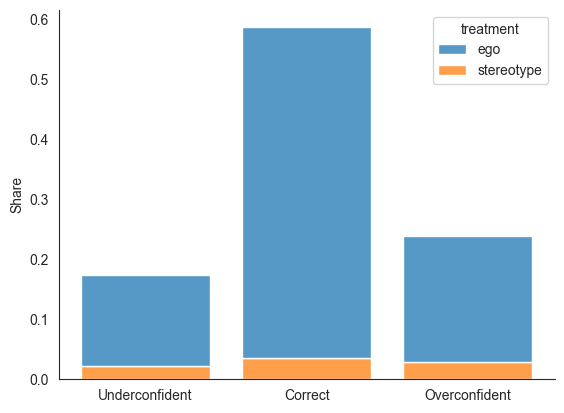

In [141]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates, 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')

Text(0.5, 1.0, 'Misspecifications')

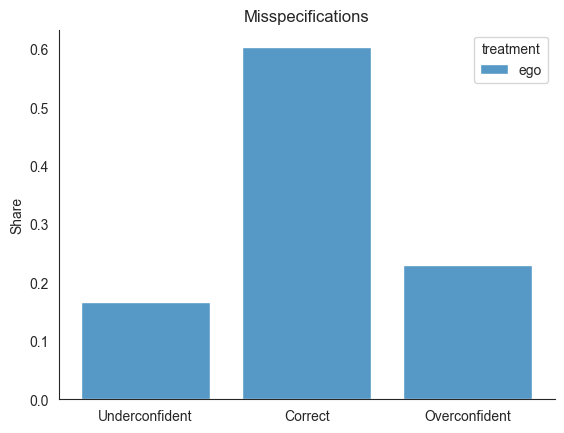

In [142]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates[updates['treatment']=='ego'], 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')
plt.title('Misspecifications')

Text(0.5, 0, '')

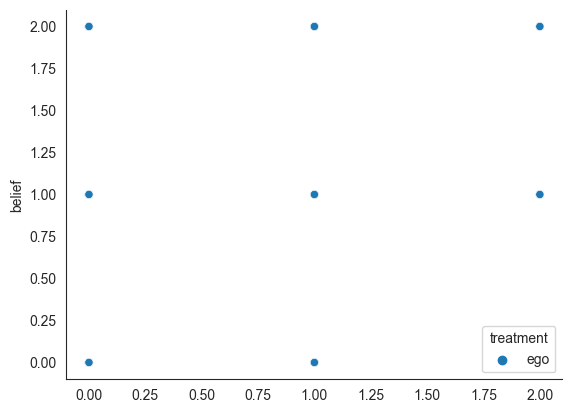

In [143]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.scatterplot(x="type", y='belief', hue="treatment", data=updates[updates['treatment']=='ego'])
sns.despine()
plt.xlabel('')


## Add a column that indicates if their type-belief changed from the previous round

In [144]:
# assign a number code to each of the topics to create an id column that has the participant code and the topic they were updating on.
updates.loc[updates['topic']=='Math', 'topic_num'] = '1'
updates.loc[updates['topic']=='Science and Technology', 'topic_num'] = '2'
updates.loc[updates['topic']=='Verbal', 'topic_num'] = '3'
updates.loc[updates['topic']=='Pop-Culture and Art', 'topic_num'] = '4'
updates.loc[updates['topic']=='Sports and Video Games', 'topic_num'] = '5'
updates.loc[updates['topic']=='US Geography', 'topic_num'] = '6'

# make a column that combines the participant code and the topic number into a singe id for a participant in a task.
updates['player_code'] = updates['code']+updates['topic_num']

updates.reset_index(inplace=True)

 
# need to rename the columns type and rate from updates to theta and omega
updates = updates.rename(columns={'type':'theta', 'rate':'omega'})




In [145]:
### Add columns to determine how the Subject's beliefs about their type changed across rounds
# for each task, determine whether their belief changed from the initial belief or not.
# check at every row if the belief is different from the last_button. 
updates['current_belief_start'] = updates['last_button'] - updates['belief']

# for rows in which rond_number is 2 or more, check if last_button is the same as last_button in the previous round_number for that player_code
# and register the size of the belief change in the column belief_change
updates['belief_change'] = np.where(updates['round_number']>1, 
                                     updates['last_button'] - updates['last_button'].shift(1), 
                                     updates['current_belief_start'])

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['change_indicator'] = 0
updates.loc[updates['belief_change']!=0, 'change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['change_indicator_sum'] = updates.groupby('player_code')['change_indicator'].transform('sum')





Text(0.5, 1.0, 'Belief changes by treatment')

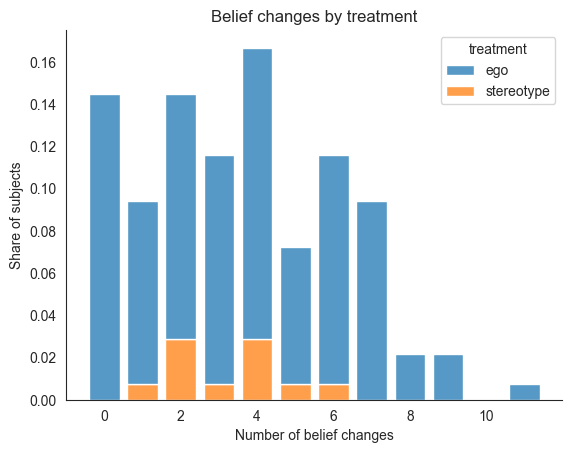

In [146]:
# if the indicator is more than 0 then the belief changed at least once and these subjects cannot possibly be dogmatic.
# plot the share of subjects for whom the belief never changed and the share for whom it did
sns.set_style("white")
sns.histplot(data=updates, x='change_indicator_sum', hue='treatment', multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('Number of belief changes')
plt.ylabel('Share of subjects')
plt.title('Belief changes by treatment')

## Likelihoods

In [147]:
## Likelihoods
#for each subject, calulate the likelihood of each of the types given the signals they saw.
# the probability matrices are needed for th calculatin of the likelihood
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]

for i in range(len(updates['player_code'].unique())):
    # get a single path for a single player
    c = updates['player_code'].unique()[i]
    player = updates.loc[updates['player_code']==c, :]
    # for each round get the history of (effort, signal) pairs up to that round
    p_t=[]
    lr_t=[]
    prior = [1/3, 1/3, 1/3]

    for t in range(11):
        
        e_t = int(player.loc[player['round_number']==t+1, 'effort'])
        theta = int(player.loc[player['round_number']==t+1, 'theta'])
        belief = int(player.loc[player['round_number']==t+1, 'belief'])
        omega = int(player.loc[player['round_number']==t+1, 'omega'])
        s_t = int(player.loc[player['round_number']==t+1, 'signal'])
        f_t = 10-s_t

        # update the belief about omega for each of the types separately
        posterior_true = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0))))
        posterior_belief = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0))))

        p_true = sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0)@posterior_true
        p_belief = sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0)@posterior_belief
        # multiply all the elements in p_true and p_belief
        l_true = np.prod(p_true)
        l_belief = np.prod(p_belief)
        # calculate the likelihood ratio
        lr_t.append(l_true/l_belief)
    # add a column to the updates data frame with the likelihood ratio for each round
    updates.loc[updates['player_code']==c, 'lr'] = lr_t

In [148]:
alpha

1.0832297109508549

## Compute alpha


In [149]:
# calculate the average of lr for the rows in which change_indicator is 1
alpha = updates.loc[(updates['change_indicator']==1) & (updates['lr']<5), 'lr'].mean()

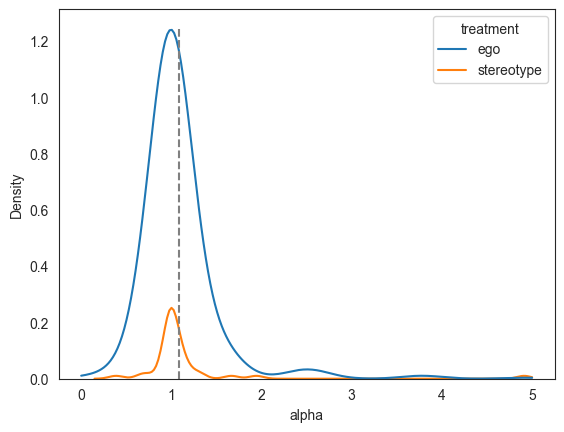

In [150]:
# estimate the distribution of alpha
# take the log of the lr
updates['log_lr'] = np.log(updates['lr'])
# plot the distribution of log_lr
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1)], x = 'lr', 
            hue='treatment', clip=(0, 5), bw_adjust=.1)
plt.xlabel('alpha')
plt.vlines([alpha], 0, 1.25, color = 'gray', linestyles='--')

In [151]:
# estimate alpha separately by treatment
alpha_ego = updates.loc[(updates['change_indicator']==1), 'lr'].mean()
alpha_ego

2.1208534925043754

In [152]:
alpha_stereotype = updates.loc[(updates['change_indicator']==1) & (updates['treatment']=='stereotype'), 'lr'].mean()
alpha_stereotype

1.384685531269693

Text(0.5, 1.0, 'Switching Threshold by treatment')

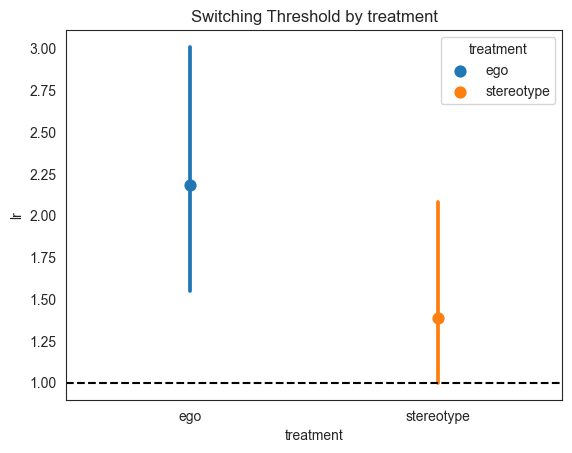

In [191]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[updates['change_indicator']==1], y='lr', x='treatment', join =False, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by treatment')

** Should it be gender/topic specific? test if they are different*
This requires adding the gender data to the updates table

In [154]:
# use alpha to simulate the switcher's path. 

## Add the simulation data and reshape to merge to the experiment's data

In [155]:
# import the simulation data
sim = pd.read_csv("../demo/data/simulation.csv")

In [156]:
updates['topic'].unique()

array(['Science and Technology', 'Math', 'Verbal', 'Pop-Culture and Art',
       'Sports and Video Games', 'US Geography'], dtype=object)

In [157]:
# split the data by initial belief and add the relevant simulations given the initial belief and the true omega and theta
initial_L = updates.loc[updates['belief']==0]
initial_M = updates.loc[updates['belief']==1]
initial_H = updates.loc[updates['belief']==2]




In [158]:
# adjust the round numbers from the simulation to match the data (get rif od rounf 0 of the simulation, it was just the starting parameters)
sim['round_number_modif'] = sim['round_number']+1
sim['round_number_modif'] = sim['round_number_modif'].astype(int)

# split the simulations by initial beliefs
sim_L = sim[['e_lr_L', 'e_dog_L', 'e_bay', 'e_ss', 'theta_lr_L', 'theta', 'omega', 'round_number_modif']]
sim_M = sim[['e_lr_M', 'e_dog_M', 'e_bay', 'e_ss', 'theta_lr_M', 'theta', 'omega', 'round_number_modif']]
sim_H = sim[['e_lr_H', 'e_dog_H', 'e_bay', 'e_ss', 'theta_lr_H', 'theta', 'omega', 'round_number_modif']]



In [159]:
sim_L = sim_L.rename(columns={'e_lr_L':'switcher', 
                      'e_dog_L':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'theta_lr_L':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_M = sim_M.rename(columns={'e_lr_M':'switcher', 
                      'e_dog_M':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'theta_lr_M':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_H = sim_H.rename(columns={'e_lr_H':'switcher', 
                      'e_dog_H':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'theta_lr_H':'switcher_belief',
                      'round_number_modif':'round_number'})

In [160]:
sim_L['belief'] = 0
sim_M['belief'] = 1
sim_H['belief'] = 2

In [161]:
sim = pd.concat([sim_L, sim_M, sim_H])

In [162]:
# merge with the update data on the round number, the belief and the theta and omega. 
updates = updates.merge(sim, on=['round_number', 'belief', 'theta', 'omega'], how='left')

## Distances to the simulated paths

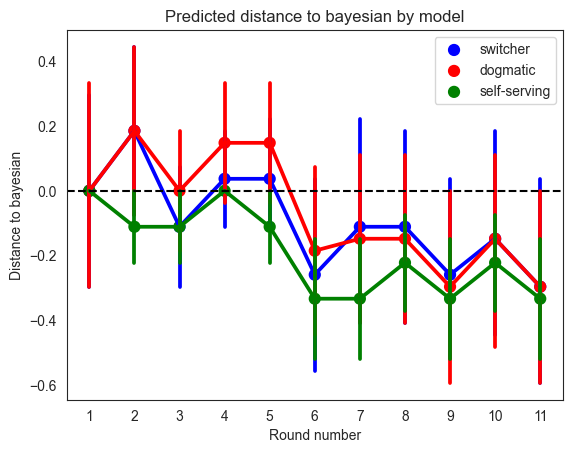

In [163]:
# compare the simulations to the bayesian simulation by taking the distance from each of the simulations to the bayesian simulation
# and then plot all of them
# first take the distance from switcher to bayesian
sim['switcher_bayesian'] = sim['switcher'] - sim['bayesian']
# then take the distance from dogmatic to bayesian
sim['dogmatic_bayesian'] = sim['dogmatic'] - sim['bayesian']
# then take the distance from self-serving to bayesian
sim['self-serving_bayesian'] = sim['self-serving'] - sim['bayesian']

# plot each of the distances as a line in the same plot
sns.set_style("white")
sns.pointplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
sns.pointplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
sns.pointplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Distance to bayesian')
plt.xlabel('Round number')
plt.title('Predicted distance to bayesian by model')
plt.legend()

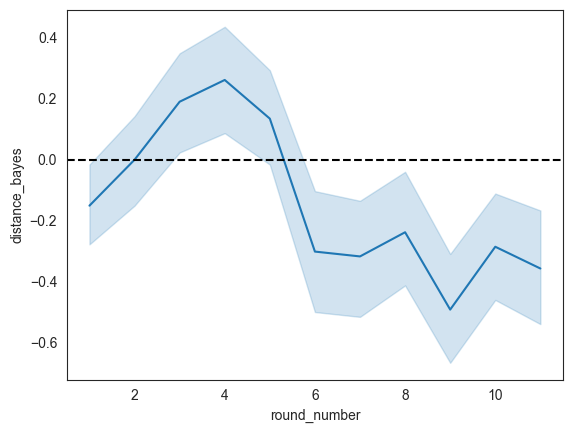

In [184]:
# compute the distance between the observed effort choices and what a bayesian agent would have done
updates['distance_bayes'] = updates['effort']- updates['bayesian']

# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_bayes')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 

plt.savefig('distance_bayes.png', dpi=300)


## Do the plots for each case of misspecification separately. 


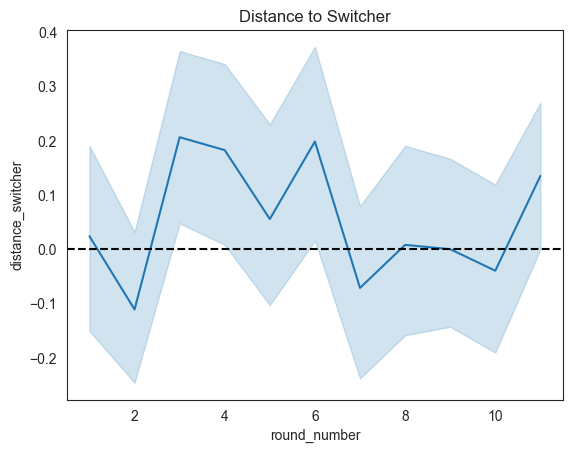

In [187]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher'] = updates['effort'] - updates['switcher']
updates['distance_dogmatic'] = updates['effort'] - updates['dogmatic']
updates['distance_bayesian'] = updates['effort'] - updates['bayesian']
updates['distance_self-serving'] = updates['effort'] - updates['self-serving']

# plot the distance over rounds for each of the MODES

# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_switcher')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher')
plt.savefig('../../figures/distance_switcher.png')

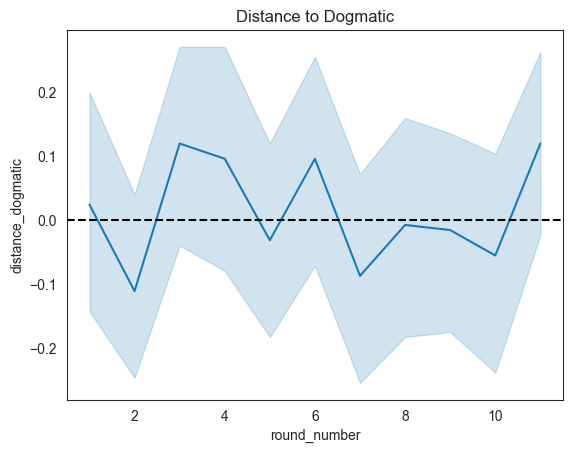

In [189]:
# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_dogmatic')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic')

plt.savefig('../../figures/distance_dogmatic.png')

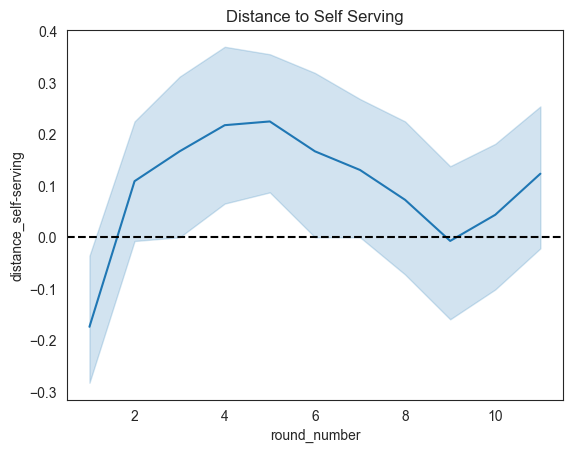

In [190]:
# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving')

plt.savefig('../../figures/distance_self-serving.png')

In [168]:
# create a function that takes in theta and omega and the data and returns 8 plots
def plot(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0])
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1])
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [169]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot(updates, t, o)
        plt.savefig('../../figures/updates_'+str(t)+str(o)+'.png')
        plt.close()

In [170]:
# create a function that takes in theta and omega and the data and returns 8 plots and plots each treatment separately
def plot_treatment(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [171]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot_treatment(updates, t, o)
        plt.savefig('../../figures/updates_by_treatment'+str(t)+str(o)+'.png')
        plt.close()

# Try to Classify subjects based on their behavior

In [172]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'misspecification_num', 'topic_num', 'player_code',
       'current_belief_start', 'belief_change', 'change_indicator',
       'change_indicator_sum', 'lr', 'log_lr', 'switcher', 'dogmatic',
       'bayesian', 'self-serving', 'switcher_belief', 'distance_bayes',
       'distance_switcher', 'distance_dogmatic', 'distance_bayesian',
       'distance_self-serving'],
      dtype='object')

In [173]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher_abs'] = np.abs(updates['effort'] - updates['switcher'])
updates['distance_dogmatic_abs'] = np.abs(updates['effort'] - updates['dogmatic'])
updates['distance_bayesian_abs'] = np.abs(updates['effort'] - updates['bayesian'])
updates['distance_self-serving_abs'] = np.abs(updates['effort'] - updates['self-serving'])

# create a new data set with the sum the computed distences by player_code for each of the models
distances = pd.DataFrame()
distances['distance_switcher_sum'] = updates.groupby('player_code')['distance_switcher_abs'].sum()
distances['distance_dogmatic_sum'] = updates.groupby('player_code')['distance_dogmatic_abs'].sum()
distances['distance_bayesian_sum'] = updates.groupby('player_code')['distance_bayesian_abs'].sum()
distances['distance_self-serving_sum'] = updates.groupby('player_code')['distance_self-serving_abs'].sum()

# for each player_code, return the model that has the smallest sum
distances['best_model'] = np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)

# merge with the updates data 
updates.merge(distances, on='player_code', how='left')

,index,code,round_number,effort,fails,last_button,score,topic,signal,belief,...,distance_self-serving,distance_switcher_abs,distance_dogmatic_abs,distance_bayesian_abs,distance_self-serving_abs,distance_switcher_sum,distance_dogmatic_sum,distance_bayesian_sum,distance_self-serving_sum,best_model
0,0,0zs7j0mw,1,2,9,2,16.0,Science and Technology,1,1,...,1,1,1,1,1,8,8,7,8,2
1,1,0zs7j0mw,2,0,4,1,16.0,Science and Technology,6,1,...,0,0,0,0,0,8,8,7,8,2
2,2,0zs7j0mw,3,1,7,2,16.0,Science and Technology,3,1,...,1,1,1,0,1,8,8,7,8,2
3,3,0zs7j0mw,4,0,7,0,16.0,Science and Technology,3,1,...,0,0,0,0,0,8,8,7,8,2
4,4,0zs7j0mw,5,0,8,1,16.0,Science and Technology,2,1,...,0,0,0,0,0,8,8,7,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,127,magz1oz9,7,1,5,1,11,US Geography,5,1,...,0,0,0,1,0,0,0,6,0,0
1514,128,magz1oz9,8,1,4,1,11,US Geography,6,1,...,0,0,0,1,0,0,0,6,0,0
1515,129,magz1oz9,9,1,5,1,11,US Geography,5,1,...,0,0,0,1,0,0,0,6,0,0
1516,130,magz1oz9,10,1,3,1,11,US Geography,7,1,...,0,0,0,1,0,0,0,6,0,0


In [174]:
np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)


array([0, 2, 0, 3, 0, 0, 0, 2, 0, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 3, 1, 0, 3, 2, 3, 2, 2, 1, 1, 2, 0, 3, 0, 0, 0, 0,
       0, 2, 2, 0, 3, 3, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 3, 2, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 2, 0,
       0, 3, 3, 2, 0, 0, 2, 0, 3, 0, 0, 3, 0, 3, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 2, 3, 0, 2, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0])

# Is treatment different from control?
Do they abandon misspecified beliefs faster in the steroetype treatment?
Are misspecifications more or less common

Is the classification different in the two treatments?

Is alpha different in treatment than in control?

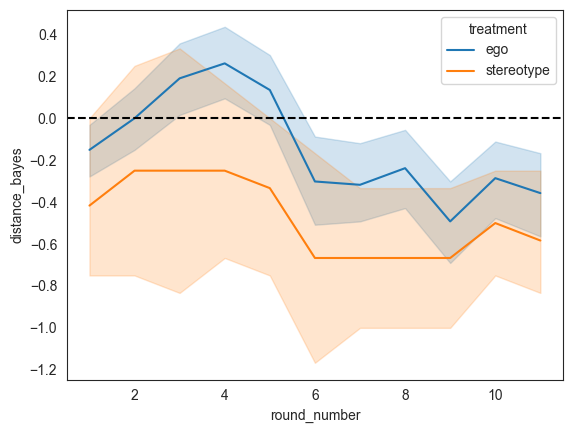

In [175]:
# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_bayes', hue='treatment')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 

plt.savefig('../../figures/distance_bayes_treatment.png')

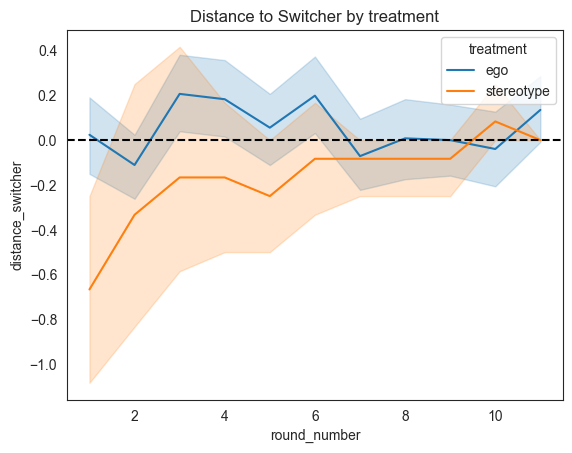

In [176]:
# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher by treatment')
plt.savefig('../../figures/distance_switcher_treatment.png')

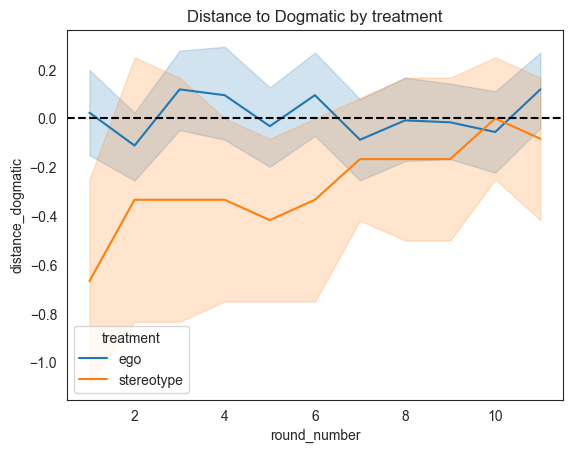

In [177]:



# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_dogmatic', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic by treatment')

plt.savefig('../../figures/distance_dogmatic_treatment.png')

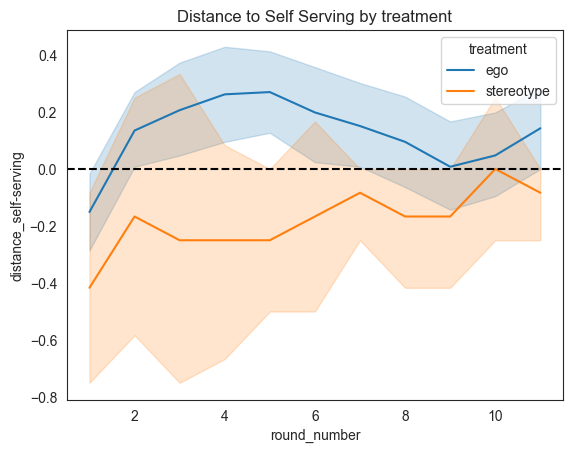

In [178]:

# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving by treatment')

plt.savefig('../../figures/distance_self-serving_treatment.png')

### T-tests
test if the difference between the observed data and the simulations are different from cero and order them from best fit to worst fit.
plot points with confidence intervals

# What are the characterising features of the subjects that are misspecified?
Do are misspecified subjects more likely to attribute it to others?

## Try to estimate parameters for Self-Attribution bias

In [179]:
updates['certainty']= updates['certainty']/100

In [180]:
updates['certainty']

0       0.75
1       0.75
2       0.75
3       0.75
4       0.75
        ... 
1513    0.75
1514    0.75
1515    0.75
1516    0.75
1517    0.75
Name: certainty, Length: 1518, dtype: object

### scores

<Axes: xlabel='score', ylabel='Density'>

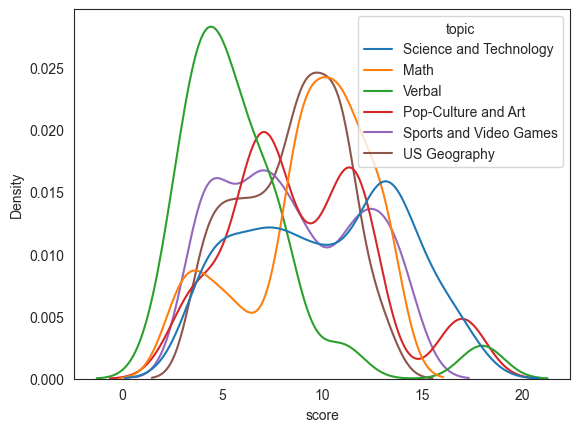

In [181]:
sns.kdeplot(data=updates, x='score', hue='topic')

<Axes: xlabel='belief', ylabel='Density'>

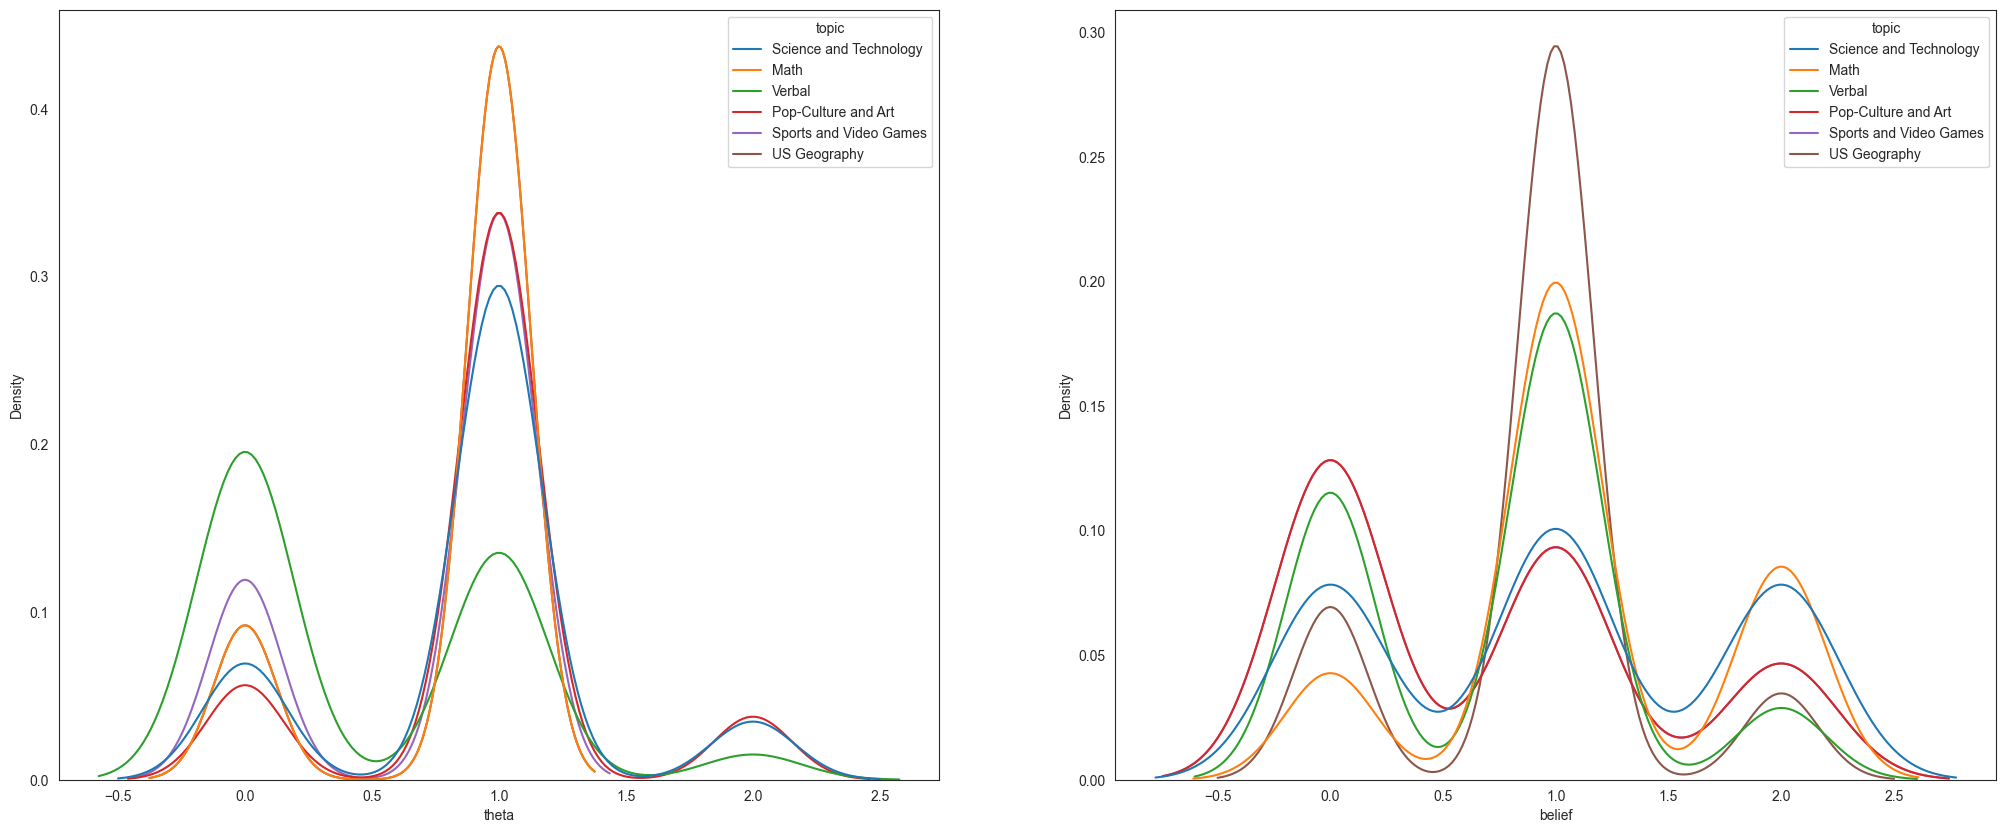

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
sns.kdeplot(data=updates, x='theta', hue='topic', ax=axs[0])
sns.kdeplot(data=updates, x='belief', hue='topic', ax=axs[1])


In [183]:
updates['topic'].unique()

array(['Science and Technology', 'Math', 'Verbal', 'Pop-Culture and Art',
       'Sports and Video Games', 'US Geography'], dtype=object)